In [1]:
import sys
import os

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.optimize import linear_sum_assignment
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_Gamma_2_eta
from helper_funcs import log_delta_2_eta0

np.random.seed(0)
random.seed(0)

# Set Parameters

In [2]:
date = "2023-04-14" # this is the subfolder where we held the results for our case study

param_folder = "../params/case_study/" + date
plot_folder = "../plt/case_study/" + date

methods = ["control","BFGS","SAGA","SVRG","GD","CG"]

K = [3,3]

partial_Es = [0.0,0.5,1.0]

tol = 1e-2

optims = {}
times_to_converge = {}
epochs_to_converge = {}
lls = {}

# Load HMMs

In [3]:
for method in methods:
    for partial_E in partial_Es:
        if method in ["BFGS","CG","GD","control"] and partial_E > 0.0:
            pass
        else:
            
            # get best ll
            best_ll = -np.infty
            best_fname = param_folder + "/case_study_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            
            # initialize lls
            lls[(method,partial_E)] = []
            
            # initialize epochs
            epochs_to_converge[(method,partial_E)] = []
            
            # initialize times
            times_to_converge[(method,partial_E)] = []
            
            for rand_seed in range(50):
                
                fname = param_folder + "/case_study_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                
                try:
                    with open(fname, 'rb') as f:
                        optim = pickle.load(f)
                except:
                    epochs_to_converge[(method,partial_E)].append(np.nan)
                    times_to_converge[(method,partial_E)].append(np.nan)
                    lls[(method,partial_E)].append(np.nan)
                    continue
                
                # check for some issue (likely nan in theta)
                if len(optim.time_trace) == 0:
                    epochs_to_converge[(method,partial_E)].append(np.nan)
                    times_to_converge[(method,partial_E)].append(np.nan)
                    lls[(method,partial_E)].append(np.nan)
                    continue
                    
                
                # get convergence ind
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                
                epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                times_to_converge[(method,partial_E)].append(optim.time_trace[converge_ind])
                lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])
                
                if optim.log_like_trace[-1] > best_ll:    
                    optims[(method,partial_E)] = optim
                    best_fname = fname
                    best_ll = optim.log_like_trace[-1]

# Get best model

In [4]:
methods = ["BFGS","CG","GD","SAGA","SVRG"]
cmap = cm.get_cmap('tab10')

linestyles = {("BFGS",0.0):("black","-"),
              ("CG",0.0)  :("black","--"),
              ("GD",0.0)  :("black",":"),
              ("SAGA",0.0):(cmap(0),"-"),
              ("SAGA",0.5):(cmap(0),"--"),
              ("SAGA",1.0):(cmap(0),":"),
              ("SVRG",0.0):(cmap(1),"-"),
              ("SVRG",0.5):(cmap(1),"--"),
              ("SVRG",1.0):(cmap(1),":")}

ll_star = optims[("BFGS",0.0)].log_like_trace[-1]
theta_star = optims[("BFGS",0.0)].theta
eta_star = optims[("BFGS",0.0)].eta
eta0_star = optims[("BFGS",0.0)].eta0

for key in optims:
    
    if ll_star < optims[key].log_like_trace[-1]:
        
        update_ll = True
        for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
            if "log_sig" in optims[key].theta[k0][feature]:
                if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                    update_ll = False
                    break
                        
        if update_ll:
            ll_star = optims[key].log_like_trace[-1]
            Gamma_star = np.exp(optims[key].log_Gamma)
            theta_star = optims[key].theta
            eta_star = optims[key].eta
            eta0_star = optims[key].eta0

# Plot Boxplots 

('SAGA', 0.0)
('SAGA', 0.5)
('SAGA', 1.0)
('SVRG', 0.0)
('SVRG', 0.5)
('SVRG', 1.0)
('BFGS', 0.0)
('SAGA', 0.0)
('SAGA', 0.5)
('SAGA', 1.0)
('SVRG', 0.0)
('SVRG', 0.5)
('SVRG', 1.0)
('BFGS', 0.0)


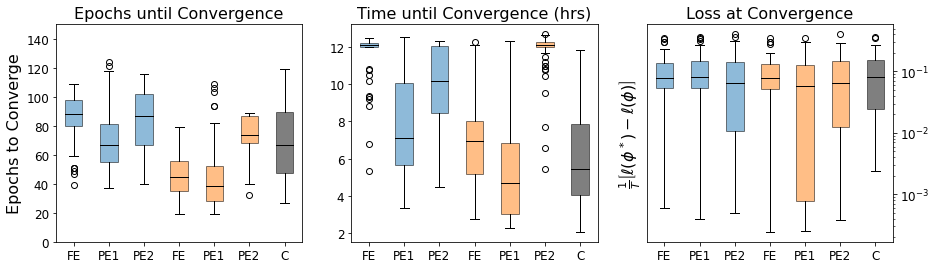

In [10]:
fig1, axs1 = plt.subplots(1,3,figsize = (15,4))

cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

keys = [("SAGA",0.0),
        ("SAGA",0.5),
        ("SAGA",1.0),
        ("SVRG",0.0),
        ("SVRG",0.5),
        ("SVRG",1.0),
        ("BFGS",0.0)]

labs = ["FE","PE1","PE2","FE","PE1","PE2","C"]

###

data_to_plot = []
for key in keys:
    
    data_to_plot.append(epochs_to_converge[key])

box = axs1[0].boxplot(data_to_plot, 
                      whiskerprops=dict(color="black"),
                      medianprops=dict(color="black"),
                      patch_artist=True,
                      labels=labs)

linestyles = {("BFGS",0.0):("black","-"),
              ("CG",0.0)  :("black","--"),
              ("GD",0.0)  :("black",":"),
              ("SAGA",0.0):(cmap(0),"-"),
              ("SAGA",0.5):(cmap(0),"--"),
              ("SAGA",1.0):(cmap(0),":"),
              ("SVRG",0.0):(cmap(1),"-"),
              ("SVRG",0.5):(cmap(1),"--"),
              ("SVRG",1.0):(cmap(1),":")}

for patch, key in zip(box['boxes'], keys):
    print(key)
    patch.set_facecolor(linestyles[key][0])
    patch.set_alpha(0.5)

axs1[0].set_ylabel("Epochs to Converge",fontsize=16)
axs1[0].set_ylim([0,150])
axs1[0].set_title("Epochs until Convergence",fontsize=16)
axs1[0].tick_params(axis='both', which='major', labelsize=12)

###

data_to_plot = []
for key in keys:
    data_to_plot.append([x/3600 for x in times_to_converge[key]])

box = axs1[1].boxplot(data_to_plot, 
                      whiskerprops=dict(color="black"),
                      medianprops=dict(color="black"),
                      patch_artist=True,
                      labels=labs)

linestyles = {("BFGS",0.0):("black","-"),
              ("CG",0.0)  :("black","--"),
              ("GD",0.0)  :("black",":"),
              ("SAGA",0.0):(cmap(0),"-"),
              ("SAGA",0.5):(cmap(0),"--"),
              ("SAGA",1.0):(cmap(0),":"),
              ("SVRG",0.0):(cmap(1),"-"),
              ("SVRG",0.5):(cmap(1),"--"),
              ("SVRG",1.0):(cmap(1),":")}

for patch, key in zip(box['boxes'], keys):
    print(key)
    patch.set_facecolor(linestyles[key][0])
    patch.set_alpha(0.5)

#axs1[1].set_ylabel("Time to Converge",fontsize=16)
#axs1[1].set_ylim([0,150])
axs1[1].set_title("Time until Convergence (hrs)",fontsize=16)
axs1[1].tick_params(axis='both', which='major', labelsize=12)

#######

data_to_plot = []
for key in keys:
    data_to_plot.append(ll_star - lls[key])

box = axs1[2].boxplot(data_to_plot, 
                       whiskerprops=dict(color="black"),
                       medianprops=dict(color="black"),
                       patch_artist=True,
                       labels=labs)

linestyles = {("BFGS",0.0):("black","-"),
              ("CG",0.0)  :("black","--"),
              ("GD",0.0)  :("black",":"),
              ("SAGA",0.0):(cmap(0),"-"),
              ("SAGA",0.5):(cmap(0),"--"),
              ("SAGA",1.0):(cmap(0),":"),
              ("SVRG",0.0):(cmap(1),"-"),
              ("SVRG",0.5):(cmap(1),"--"),
              ("SVRG",1.0):(cmap(1),":")}

for patch, key in zip(box['boxes'], keys):
    patch.set_facecolor(linestyles[key][0])
    patch.set_alpha(0.5)

axs1[2].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi^*) - \ell(\phi)\right]$",fontsize=16)
axs1[2].set_yscale("log")
axs1[2].set_title("Loss at Convergence",fontsize=16)
axs1[2].tick_params(axis='both', which='major', labelsize=12)
axs1[2].yaxis.tick_right()


if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

fig1.savefig(plot_folder + '/boxplots_case_study.png',dpi=500,bbox_inches='tight')

# Plot Scatterplots

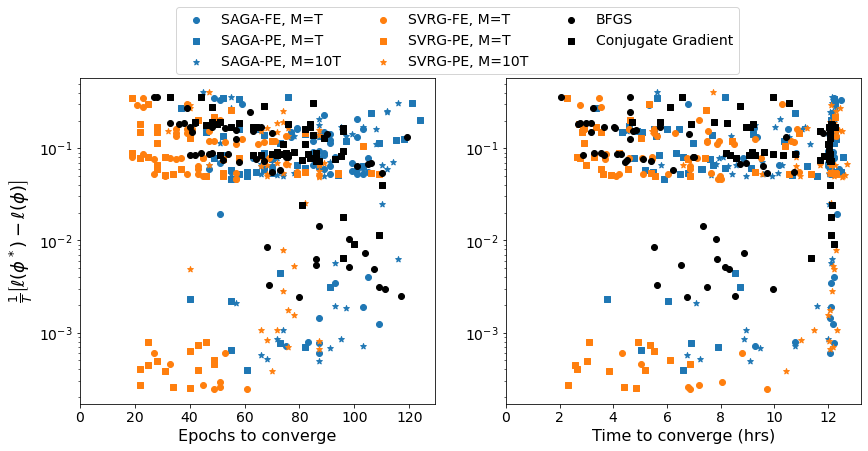

In [17]:
fig1, axs1 = plt.subplots(1,2,figsize = (14,6))

cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

keys = [("SAGA",0.0),
        ("SAGA",0.5),
        ("SAGA",1.0),
        ("SVRG",0.0),
        ("SVRG",0.5),
        ("SVRG",1.0),
        ("BFGS",0.0),
        ("CG",0.0)]

labs = ["BFGS",0,0.5,1,0,0.5,1]

# define linestyles
pointstyles = {("BFGS",0.0):("black","o"),
               ("CG",0.0)  :("black","s"),
               ("GD",0.0)  :("black","*"),
               ("SVRG",0.0):(cmap(1),"o"),
               ("SVRG",0.5):(cmap(1),"s"),
               ("SVRG",1.0):(cmap(1),"*"),
               ("SAGA",0.0):(cmap(0),"o"),
               ("SAGA",0.5):(cmap(0),"s"),
               ("SAGA",1.0):(cmap(0),"*")}

legend_elem = {("BFGS",0.0): "BFGS",
               ("CG",0.0)  : "Conjugate Gradient",
               ("GD",0.0)  : "GD",
               ("SVRG",0.0): "SVRG-FE, M=T",
               ("SVRG",0.5): "SVRG-PE, M=T",
               ("SVRG",1.0): "SVRG-PE, M=10T",
               ("SAGA",0.0): "SAGA-FE, M=T",
               ("SAGA",0.5): "SAGA-PE, M=T",
               ("SAGA",1.0): "SAGA-PE, M=10T"}

# get data
times_to_plot = []
for key in keys:
    times_to_plot.append([x/3600 for x in times_to_converge[key]])
    
epochs_to_plot = []
for key in keys:
    epochs_to_plot.append(epochs_to_converge[key])

lls_to_plot = []
for key in keys:
    lls_to_plot.append(ll_star - lls[key])

# plot data
for key,time_data,epoch_data,ll_data in zip(keys,times_to_plot,epochs_to_plot,lls_to_plot):
    axs1[0].scatter(epoch_data,ll_data,
                    color = pointstyles[key][0],
                    marker = pointstyles[key][1])
    axs1[1].scatter(time_data,ll_data,
                    color = pointstyles[key][0],
                    marker = pointstyles[key][1])


# adjust axes
axs1[0].set_yscale('log')
axs1[0].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi^*) - \ell(\phi)\right]$",fontsize=18)
axs1[0].set_xlabel("Epochs to converge",fontsize=16)
axs1[0].set_xlim([0,None])
axs1[0].tick_params(axis='both', which='major', labelsize=14)

axs1[1].set_yscale('log')
#axs1[1].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi^*) - \ell(\phi)\right]$",fontsize=16)
axs1[1].set_xlabel("Time to converge (hrs)",fontsize=16)
axs1[1].set_xlim([0,None])
axs1[1].tick_params(axis='both', which='major', labelsize=14)

fig1.legend([legend_elem[key] for key in keys],
            loc='upper center', 
            fontsize=14,
            bbox_to_anchor=(0.5, 1.06),
            ncol=3)

#axs1.legend([legend_elem[key] for key in keys],fontsize=12)

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

fig1.savefig(plot_folder + '/scatterplot_case_study.png',dpi=500,bbox_inches='tight')

# Plot Log-Likelihood Traces

In [47]:
def plot_ll(optims,xlims=None,ylims=None):
    
    labels = {("SAGA",0.0): "SAGA-FE, M=T",
              ("SAGA",0.5): "SAGA-PE, M=T",
              ("SAGA",1.0): "SAGA-PE, M=10T",
              ("SVRG",0.0): "SVRG-FE, M=T",
              ("SVRG",0.5): "SVRG-PE, M=T",
              ("SVRG",1.0): "SVRG-PE, M=10T",
              ("BFGS",0.0): "BFGS",
              ("CG",0.0)  : "Conjugate Gradient",
              ("GD",0.0)  : "Gradient Descent",}
    
    linestyles = {("BFGS",0.0):("black","-"),
                  ("CG",0.0)  :("black","--"),
                  ("GD",0.0)  :("black",":"),
                  ("SAGA",0.0):(cmap(0),"-"),
                  ("SAGA",0.5):(cmap(0),"--"),
                  ("SAGA",1.0):(cmap(0),":"),
                  ("SVRG",0.0):(cmap(1),"-"),
                  ("SVRG",0.5):(cmap(1),"--"),
                  ("SVRG",1.0):(cmap(1),":")}

    legend_elements = []

    for key in labels:
        legend_elements.append(Line2D([0], [0], 
                                      color=linestyles[key][0], 
                                      linestyle=linestyles[key][1], 
                                      label=labels[key]))
        
    fig1, axs1 = plt.subplots(1,2,figsize = (14,6))
    
    # get new optimal value
    ll_star0 = optims[('SAGA', 1.0)].log_like_trace[-1]
    print(ll_star0)
    
    # make lines
    for method in methods:
        for partial_E in [0,0.5,1]:
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            if (method,partial_E) in optims:

                optim = optims[(method,partial_E)]
                ltyp = linestyles[(method,partial_E)][1]

                eind = min(np.where(np.array(optim.epoch_trace) >= 150)[0],
                           default=len(optim.grad_norm_trace))

                axs1[0].plot([x / 3600 for x in optim.time_trace[:eind]],
                              ll_star0-optim.log_like_trace[:eind],
                              color=linestyles[(method,partial_E)][0],
                              linestyle=linestyles[(method,partial_E)][1])
                
                axs1[1].plot(optim.epoch_trace[:eind],
                            ll_star0-optim.log_like_trace[:eind],
                            color=linestyles[(method,partial_E)][0],
                            linestyle=linestyles[(method,partial_E)][1])
                
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
         
    
    
    axs1[0].set_xlabel("Hours of Computation",fontsize=18)
    axs1[1].set_xlabel("Epoch",fontsize=18)
    
    axs1[0].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi^*) - \ell(\phi)\right]$",fontsize=18)
    axs1[0].set_yscale("log")
    axs1[1].set_yscale("log")
    fig1.legend(handles=legend_elements,
                loc='upper center', 
                fontsize=14,
                bbox_to_anchor=(0.5, 1.1),
                ncol=3)

    axs1[0].tick_params(axis='both', which='major', labelsize=14)
    axs1[1].tick_params(axis='both', which='major', labelsize=14)
    
    # add points          
    for method in methods:
        for partial_E in [0,0.5,1]:
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            if (method,partial_E) in optims:
                optim = optims[(method,partial_E)]
                eind = min(np.where(np.array(optim.epoch_trace) >= 150)[0],
                           default=len(optim.grad_norm_trace))
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                
                if converge_ind >= eind-1:
                    continue
                    
                axs1[0].plot(optim.time_trace[converge_ind] / 3600,
                             ll_star0-optim.log_like_trace[converge_ind],
                             color = pointstyles[(method,partial_E)][0],
                             marker = pointstyles[(method,partial_E)][1])

                axs1[1].plot(optim.epoch_trace[converge_ind],
                             ll_star0-optim.log_like_trace[converge_ind],
                             color = pointstyles[(method,partial_E)][0],
                             marker = pointstyles[(method,partial_E)][1])
    
    fig1.savefig(plot_folder + "/log-like_v_epoch_K-%d-%d.png"%(K[0],K[1]),
                 dpi=500,
                 bbox_inches='tight')
    fig1.show()
                
    return

-0.4809909563185551


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_24352/2396310286.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


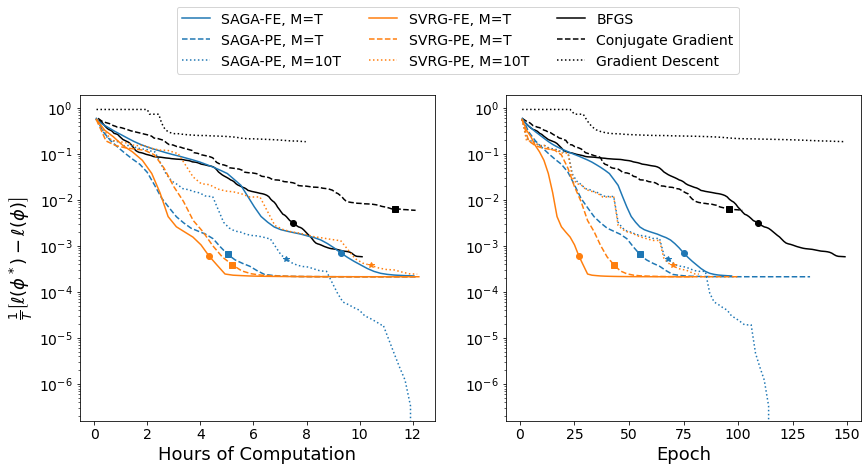

In [48]:
if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)
    
plot_ll(optims)